In [1]:
'''
/**
* 2/2021
* Pontifícia Universidade Católica de Minas Gerais
* Advisor - Prof. Alexei Machado
* Designed by:
* @author Igor Machado Seixas - 561897
* @version 0.10a
*/
'''

'''
/**
* Libraries:
* Numpy - PIL - sklearn - torch - sklearn
*/
'''

import numpy as np
import os
import random
import itertools
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

from torchvision import transforms
from torchvision.utils import make_grid
import torchvision.models as models

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from PIL import Image
from PIL import ImageOps

import matplotlib.pyplot as plt

from pathlib import Path

In [2]:
# Configuration.
#root_directory = f'..//Datasets//Colombiam//thyroid-cut'
path = os.getcwd()
root_directory = os.path.dirname(path)+'\Datasets\Colombiam\\thyroid-crop-small-background-360-train-3'
test_root_directory = os.path.dirname(path)+'\Datasets\Colombiam\\thyroid-crop-small-background-360-test-3'
print(root_directory)
train_ratio = 1
validation_ratio = .25
rotation_angle = 90

random_seed = 15
torch.manual_seed(random_seed) # Preavesibility
batch_size = 32
pin_memory = True
#num_workers = 4

c:\Users\igormseixas\TCC_II\Datasets\Colombiam\thyroid-crop-small-background-360-train-3


In [3]:
# Data preparation.
# transform_train = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), transforms.Grayscale(num_output_channels=1)])
# transform_test = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), transforms.Grayscale(num_output_channels=1)])
# transform_train = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
# transform_test = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
#transform_train = transforms.Compose([transforms.CenterCrop(300), transforms.ToTensor(), transforms.Normalize(mean=[0.35,], std=[0.1,])])
#transform_test = transforms.Compose([transforms.CenterCrop(300), transforms.ToTensor(), transforms.Normalize(mean=[0.35,], std=[0.1,])])
#transform_train = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.25,], std=[0.5,])])
#transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.25,], std=[0.5,])])
transform_train = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.0193, 0.4060, 0.0208], std=[0.0791, 0.4780, 0.0788])])
transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.0014, 0.0416, 0.0015], std=[0.0791, 0.4780, 0.0788])])
#transform_train = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.2991,], std=[0.1638,])])
#transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.2937,], std=[0.1543,])])
#transform_train = transforms.Compose([transforms.ToTensor()])
#transform_test = transforms.Compose([transforms.ToTensor()])

In [4]:
# Device configuration.
if torch.cuda.is_available(): 
    device = torch.device('cuda')
    print('Running on cuda')
    # Distribute across "2" gpus
    #model = nn.DataParallel(model)
    #print('Running on multiple gpus')
else:
    device = torch.device('cpu')
    print('Running on cpu')

Running on cuda


In [5]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, batch_size
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [6]:
# Function to create a dataset with a set of training and test set and a set of classes.
# Param img_folder - contains the image folder path.
# Param train_size - contains the size of the training set.
# Param...
def load_dataset(img_folder, test_folder, train_ratio, validation_ratio, transform_train, transform_test, rotation_angle=0, batch_size=64, data_augmentation=False):
    image_data_train=[]
    image_data_val=[]
    image_data_test=[]
    image_class=[]

    file_name_memory = []
    file_name_memory_train = []
    file_name_memory_val = []

    # Iteract in the files directory.
    for dir in os.listdir(img_folder):
        if dir.startswith('8'): continue
        print("Train and Validation:", dir)
        file_name_memory = [s for s in os.listdir(os.path.join(img_folder, dir))] # Get all the names.
        file_name_memory = list(zip(*(iter(file_name_memory),) * 1)) # Create group of 1 files.
        # Randonize the names by group.
        random.Random(random_seed).shuffle(file_name_memory)
        # Get train_ratio to put into file_name_memory_train and file_name_memory_test.
        file_name_memory_train = file_name_memory[:int(len(file_name_memory)*train_ratio)] # First n*train_ratio elements.
        file_name_memory_val = file_name_memory_train[:int(len(file_name_memory_train)*validation_ratio)] # First n*validation_ratio elements.
        
        # Flat train list and validation.
        file_name_memory_train = list(itertools.chain(*file_name_memory_train))
        file_name_memory_val = list(itertools.chain(*file_name_memory_val))

        for file in os.listdir(os.path.join(img_folder, dir)):
            image_path = os.path.join(img_folder, dir,  file)

            # The first train_ratio times append to the image_data_train.
            if file in file_name_memory_train:
                image = transform_train(Image.open(image_path)) # Train transformation for train and val.
                image = np.array(image)
                if file in file_name_memory_val:
                    # Append de image data to the validation set.
                    image_data_val.append([image,int(dir[0])]) 
                else:
                    # Append de image data to the training set.
                    image_data_train.append([image,int(dir[0])])

            #else:
            #    image = transform_test(Image.open(image_path)) # Test transformation for train and val.
            #    image = np.array(image)
            #    # Append de image data to an image_data_x array and a image_data_y with the classifiers.
            #    image_data_test.append([image,int(dir[0])])

        image_class.append(dir)

    # Iteract in the files directory.
    for dir in os.listdir(test_folder):
        if dir.startswith('8'): continue
        print("Test:", dir)
        for file in os.listdir(os.path.join(test_folder, dir)):
            test_path = os.path.join(test_folder, dir,  file)
            
            image = transform_test(Image.open(test_path)) # Test transformation for train and val.
            image = np.array(image)
            # Append de image data to an image_data_x array and a image_data_y with the classifiers.
            image_data_test.append([image,int(dir[0])])


    # Defining data training, validation and test sizes.
    train_size = int(train_ratio * len(image_data_train))
    val_size = len(image_data_train) - train_size

    # Transform into DataLoader 
    train_dl = DataLoader(image_data_train, batch_size=batch_size, shuffle=True, pin_memory=pin_memory)
    val_dl = DataLoader(image_data_val, batch_size=batch_size, shuffle=False, pin_memory=pin_memory)
    test_dl = DataLoader(image_data_test, batch_size=batch_size, shuffle=False, pin_memory=pin_memory)
    classes = np.array(image_class)
    print('Train Mean and STD:', get_mean_and_std(train_dl))
    print('Validation Mean and STD:', get_mean_and_std(val_dl))
    print('Test Mean and STD:', get_mean_and_std(test_dl))

    return train_dl, val_dl, test_dl, classes

In [7]:
# Get train and test data.
train_dl, val_dl, test_dl, classes = load_dataset(root_directory, test_root_directory, train_ratio, validation_ratio, transform_train, transform_test, batch_size=batch_size)
# Print size of training, validation and test sets.
print("Training size: ", len(train_dl.dataset))
print("Validation size: ", len(val_dl.dataset))
print("Test size: ", len(test_dl.dataset))
print("Total size: ", len(train_dl.dataset)+len(val_dl.dataset)+len(test_dl.dataset))

Train and Validation: 1-4a
Train and Validation: 2-4b
Train and Validation: 3-4c
Test: 1-4a
Test: 2-4b
Test: 3-4c
Train Mean and STD: (tensor([0.1792, 0.6463, 0.1946]), tensor([1.1738, 0.7288, 1.1679]))
Validation Mean and STD: (tensor([0.1103, 0.4275, 0.1205]), tensor([0.9449, 0.6665, 0.9410]))
Test Mean and STD: (tensor([0.2672, 1.0009, 0.2914]), tensor([1.0480, 0.9796, 1.0465]))
Training size:  2844
Validation size:  948
Test size:  1568
Total size:  5360


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([32, 3, 360, 360])
Labels batch shape: torch.Size([32])


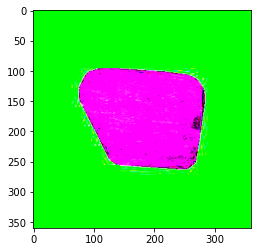

Label: 2


In [8]:
# Display image and label.
image_to_display_number = 1
train_features, train_labels = next(iter(train_dl))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[image_to_display_number].squeeze()
label = train_labels[image_to_display_number]
img = img.swapaxes(0,1)
img = img.swapaxes(1,2)
plt.imshow(img, cmap="gray", vmin=0, vmax=1)
plt.show()
print(f"Label: {label}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


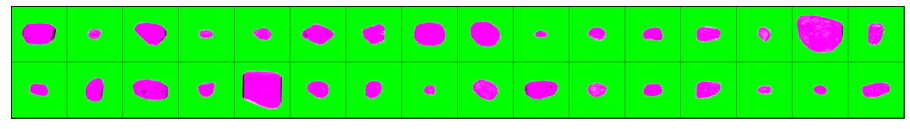

In [9]:
# Function to show the batch of the Dataset.
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(val_dl)

In [10]:
class RNet(nn.Module):
    def __init__(self):
        super(RNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels= 56, kernel_size= (13,13), stride=4, padding=(0,0))
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=56, out_channels=112, kernel_size= (7,7), stride= 1, padding=(0,0))
        self.conv3 = nn.Conv2d(in_channels=112, out_channels=224, kernel_size= (5,5), stride= 1, padding=(2,2))
        self.conv4 = nn.Conv2d(in_channels=224, out_channels=336, kernel_size= (3,3), stride= 1, padding=(1,1))
        self.conv5 = nn.Conv2d(in_channels=336, out_channels=336, kernel_size= (3,3), stride= 1, padding=(1,1))
        self.conv6 = nn.Conv2d(in_channels=336, out_channels=224, kernel_size= (3,3), stride= 1, padding=(1,1))
        self.fc1  = nn.Linear(in_features= 224, out_features= 448)
        self.fc2  = nn.Linear(in_features= 448, out_features=224)
        self.fc3  = nn.Linear(in_features= 224, out_features=112)
        self.fc4  = nn.Linear(in_features= 112, out_features=10)


    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.maxpool(x)

        x = x.reshape(x.shape[0], -1)
        x = F.dropout2d(x, 0.5)
        x = F.relu(self.fc1(x))
        x = F.dropout2d(x, 0.5)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [11]:
# Defining the model.
# AlexNet
#model = models.alexnet()
#model = models.alexnet(pretrained=True)

# MobileNet
#model = models.mobilenet_v3_large()
model = models.mobilenet_v3_large(pretrained=True)
#model = models.mobilenet_v3_small()
#model = models.mobilenet_v3_small(pretrained=True)

# GoogleLeNet
#model = models.googlenet()
#model = models.googlenet(pretrained=True)

# VGG16 
#model = models.vgg16()
#model = models.vgg16(pretrained=True)

# DenseNet121 
#model = models.densenet121()
#model = models.densenet121(pretrained=True)

# ResNet 
#model = models.resnet18()
#model = models.resnet18(pretrained=True)

# WideResNet
#model = models.wide_resnet50_2()
#model = models.wide_resnet50_2(pretrained=True)

# RandomNet
#model = RNet()

#model.features[0] = nn.Conv2d(4, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
#modelOutputFeats = model.classifier.in_features
#model.classifier = nn.Linear(modelOutputFeats, 9)

# Transfer to Device.
model = model.to(device=device)

# Loss and optimizer.
learning_rate = 1e-3 #It was 0.07
load_model = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate) # Adam
# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1) TEST AFTERRRR
    
print(model)

MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False

In [12]:
# Check accuraccy of the training set.
# Function to give accuracy of a given data set. It will returns the predict and output to
# check using other metrics.
def check_acc(dataloader, model, device):
    # Get the data.
    num_correct = 0
    num_samples = 0
    predict = []
    target = []

    # Set model to eval
    model.eval()
    
    with torch.no_grad():
        for batch_idx, (data,targets) in enumerate(dataloader):
            #print('Batch:', batch_idx)
            data = data.to(device=device)
            targets = targets.to(device=device)

            ## Forward Pass
            scores = model(data)
            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)    

            predict = predict + predictions.to(device="cpu").numpy().tolist()
            target = target + targets.to(device="cpu").numpy().tolist()
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
        )

    result = float(num_correct) / float(num_samples) * 100
    #model.train()
    return target, predict, result



In [13]:
# CNN Configuration.
epochs = 3000

In [14]:
# Training section.
best_model_wts = copy.deepcopy(model.state_dict())
best_acc  = 0.0
best_loss = 100.0
best_epoch = 0
best_f1 = 0.0

for epoch in range(epochs):
    loss_ep = 0
    loss_ep_val = 0
    
    # Set model to train.
    model.train()

    for batch_idx, (data, targets) in enumerate(train_dl):
        data = data.to(device=device)
        targets = targets.to(device=device)
        ## Forward Pass
        optimizer.zero_grad()
        scores = model(data)
        loss = criterion(scores,targets)
        loss.backward()
        optimizer.step()
        loss_ep += loss.item()
    print(f"Loss in epoch {epoch} :::: {loss_ep/len(train_dl)}")

    # Set model to train.
    model.eval()
    
    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for batch_idx, (data,targets) in enumerate(val_dl):
            data = data.to(device=device)
            targets = targets.to(device=device)
            ## Forward Pass
            scores = model(data)
            loss_val = criterion(scores,targets)
            loss_ep_val += loss_val.item()
            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print(f"Loss validation in epoch {epoch} :::: {loss_ep_val/len(val_dl)}")
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
        )  
    
    #epoch_acc = float(num_correct) / float(num_samples) * 100
    loss_acc  = loss_ep_val/len(val_dl)
    test_output, test_predict, epoch_acc = check_acc(test_dl, model, device)
    f1_acc = f1_score(test_output, test_predict, average='weighted')
    print('F1 Score:', f1_acc)
    print('Best Score:', best_f1)

    # Deep copy the model.
    if (f1_acc >= best_f1):
        best_epoch = epoch
        best_acc  = epoch_acc
        best_loss = loss_acc
        best_f1 = f1_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    # Check the loss if is lower than 0.001 stops the training process.
    # Overfit control.
    if (loss_ep/len(train_dl)) <= 0.001:
        break

# Load the best model weights.
print ('Epoch:', best_epoch)
print ('Best Accuracy:', best_acc)
print ('Loss:', best_loss)
model.load_state_dict(best_model_wts)

Loss in epoch 0 :::: 1.3067057259966819
Loss validation in epoch 0 :::: 1.1548401415348053
Got 381 / 948 with accuracy 40.19
Got 590 / 1568 with accuracy 37.63
F1 Score: 0.3418051530568819
Best Score: 0.0
Loss in epoch 1 :::: 0.7513642662696625
Loss validation in epoch 1 :::: 1.2667771895726523
Got 532 / 948 with accuracy 56.12
Got 612 / 1568 with accuracy 39.03
F1 Score: 0.3750385095029309
Best Score: 0.3418051530568819
Loss in epoch 2 :::: 0.4456040854199549


KeyboardInterrupt: 

In [14]:
train_output, train_predict, _ = check_acc(train_dl, model, device)
print('\nResults on the training set:')
print(classification_report(train_output, train_predict))

Got 2589 / 2844 with accuracy 91.03

Results on the training set:
              precision    recall  f1-score   support

           1       0.94      0.88      0.91      1176
           2       0.86      0.93      0.90       936
           3       0.92      0.93      0.93       732

    accuracy                           0.91      2844
   macro avg       0.91      0.91      0.91      2844
weighted avg       0.91      0.91      0.91      2844



In [15]:
val_output, val_predict, _ = check_acc(val_dl, model, device)
print('\nResults on the validating set:')
print(classification_report(val_output, val_predict))

Got 746 / 948 with accuracy 78.69

Results on the validating set:
              precision    recall  f1-score   support

           1       0.83      0.79      0.81       392
           2       0.72      0.82      0.77       312
           3       0.81      0.75      0.78       244

    accuracy                           0.79       948
   macro avg       0.79      0.78      0.79       948
weighted avg       0.79      0.79      0.79       948



In [16]:
test_output, test_predict, _ = check_acc(test_dl, model, device)
print('\nResults on the test set:')
print(classification_report(test_output, test_predict))
print('\nResults as Confusion Matrix:')
print(confusion_matrix(test_output, test_predict))

Got 119 / 134 with accuracy 88.81

Results on the test set:
              precision    recall  f1-score   support

           1       0.73      0.40      0.52        20
           2       0.90      0.97      0.94       114

    accuracy                           0.89       134
   macro avg       0.81      0.69      0.73       134
weighted avg       0.88      0.89      0.87       134


Results as Confusion Matrix:
[[  8  12]
 [  3 111]]


In [35]:
tp, fn, fp, tn = confusion_matrix(test_output, test_predict).ravel()
print(tp, fn, fp, tn)
specificity = tn / (tn+fp)
sens = tp / (tp+fn)
print(specificity)
print(sens)

8 12 3 111
0.9736842105263158
0.4


In [34]:
print(roc_auc_score(test_output, test_predict))


0.6868421052631579


In [18]:
print (epoch, best_loss)
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
            }, './my_model/my_model_xxx.pt')

160 0.8475293770432473


In [12]:
# Model to be loaded.
model = models.mobilenet_v3_large(pretrained=True)
model = model.to(device=device)

# Loss and optimizer.
learning_rate = 1e-3 #It was 0.07
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate) # Adam
checkpoint = torch.load('./my_model/my_model_bi_classification/my_model_89_MobileNet_large_bi_orig.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [13]:
# Check epoch and loss.
print (checkpoint['epoch'])
print (checkpoint['loss'])

67
0.3034930234944335


In [ ]:
del model
torch.cuda.empty_cache()